## Testing different cascades

In [1]:
# imports
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

First let's count how many ears (positives) there are in our train set.

In [2]:
def count_ears_test():
    nr_ears = 0
    for photo in os.listdir('AWEForSegmentation/test'):
        mask = cv2.imread(f'./AWEForSegmentation/testannot_rect/{photo}', 0).astype(bool)
        i = 0
        while i < mask.shape[0]:
            j = 0
            while j < mask.shape[1]:
                if mask[i, j]:
                    if i == 0 or not mask[i-1, j]:                  # upper row
                        if j == 0 or not mask[i, j-1]:              # upper left corner
                            nr_ears += 1
                j += 1
            i += 1
    return nr_ears

NR_EARS = count_ears_test()

To get all separate bounding boxes for each picture I addapted the `positive_description_file()` function
from `data_preparation.ipynb`. I deleted photo `0058.png`, because it's the only one with covered bounding boxes.

In [3]:
def positive_description_file_test():
    info = {}
    for photo in os.listdir('AWEForSegmentation/test'):
        mask = cv2.imread(f'./AWEForSegmentation/testannot_rect/{photo}', 0).astype(bool)
        info[photo] = []
        unfinished = {}
        i = 0
        while i < mask.shape[0]:
            j = 0
            while j < mask.shape[1]:
                if mask[i, j]:
                    if i == 0 or not mask[i-1, j]:                  # upper row
                        if j == 0 or not mask[i, j-1]:              # upper left corner
                            unfinished[j] = {'start_y': i}          # there can only be one unfinished on y=j
                            width = 0
                            while j < mask.shape[1] and mask[i, j]:
                                j += 1
                                width += 1
                            unfinished[j-width]['width'] = width
                    elif mask[i-1, j] and mask[i+1, j]:             # left column
                        j += unfinished[j]['width']
                    elif mask[i-1, j] and not mask[i+1, j]:         # lower left corner
                        height = i - unfinished[j]['start_y'] + 1
                        info[photo].append([j, unfinished[j]['start_y'], unfinished[j]['width'], height])
                        j += unfinished[j]['width']
                    else:
                        print(photo, i, j)
                else:
                    j += 1
            i += 1
    with open('test_bounding_boxes.json', 'w') as f:
        f.write(json.dumps(info))

positive_description_file_test()

Below we have functions for 2 tests, one on captured video from webcam and one on test images in *AWEForSegmentation*
dataset.

In [37]:
def camera_test(cascade_folder):
    """Shows recognized ears with cascade from 'cascade_folder' on video from webcam."""
    # Load the cascade
    ear_cascade = cv2.CascadeClassifier(f'{cascade_folder}/cascade.xml')

    # To capture video from webcam.
    cap = cv2.VideoCapture(0)

    while True:
        # Read the frame
        _, img = cap.read()
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect the faces
        ears = ear_cascade.detectMultiScale(img, 1.1, 25)
        for (x, y, w, h) in ears:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        # Draw the rectangle around each ear
        # Display
        cv2.imshow('img', img)
        # Stop if escape key is pressed
        k = cv2.waitKey(30) & 0xff
        if k==27:
            break
    # Release the VideoCapture object
    cap.release()


def awe_test(cascade_folder, scaleFactor, minNeighbours, test_visual_folder=None):
    """Tests cascade from 'cascade_folder' using parameters 'scaleFactor' and 'minNeighbours'.
    If test_visual_folder is provided, the function will create a visual representation in folder 'test'."""
    results = {'TP': 0, 'FP': 0}     # results will be averaged over all test images
    ear_cascade = cv2.CascadeClassifier(f'{cascade_folder}/cascade.xml')
    if test_visual_folder:
        if not os.path.exists(f'test/{test_visual_folder}'):
                os.makedirs(f'test/{test_visual_folder}')
    with open("test_bounding_boxes.json", "r") as f:
        bounding_boxes = json.load(f)
    for photo in os.listdir('AWEForSegmentation/test'):
        img = cv2.imread(f'./AWEForSegmentation/test/{photo}', cv2.IMREAD_UNCHANGED)
        ears = ear_cascade.detectMultiScale(img, scaleFactor, minNeighbours)
        for (x, y, w, h) in ears:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw the rectangle around each ear
            false_pos = True
            for (xt, yt, wt, ht) in bounding_boxes[photo]:
                mask = np.zeros(img.shape[:2])
                mask[yt:yt+ht, xt:xt+ht] = 1            # 1 where the bounding box is
                intersection = np.sum(mask[y:y+h, x:x+h])       # where our detection is
                mask[y:y+h, x:x+h] = 1                  # add detection to mask to get union
                iou = intersection / np.sum(mask)
                if iou > 0.5:
                    results['TP'] += 1
                    false_pos = False
            if false_pos: results['FP'] += 1
        if test_visual_folder:
            for (xt, yt, wt, ht) in bounding_boxes[photo]:
                cv2.rectangle(img, (xt, yt), (xt + wt, yt + ht), (0, 0, 255), 1)
            cv2.imwrite(f'test/{test_visual_folder}/{photo[:4]}_{cascade_folder}.png', img)

    results['TPR'] = results['TP'] / NR_EARS            # recall - true positive rate
    if results['TP'] + results['FP'] != 0:
        results['PPV'] = results['TP'] / (results['TP'] + results['FP'])  # precision - positive predictive value
    else: results['PPV'] = 0
    if results['TPR'] + results['PPV'] != 0:
        results['F1'] = 2 * results['TPR'] * results['PPV'] / (results['TPR'] + results['PPV'])     # F1 score
    else: results['F1'] = 0

    return results

In [ ]:
camera_test('cascadecoco_people')

In [38]:
r = awe_test('cascade_coco_people_all_maxFAR03', 1.1, 6, 'test_best')

sum:  175


Next block creates a table *results* that holds test results for different cascades and minNeighbours parameter used in
detection.

In [39]:
cascades = ['cascade_basic', 'cascade_basic_all', 'cascade_basic_maxFAR03', 'cascade_gs',
            'cascade_gs_all', 'cascade_gs_maxFAR03', 'cascade_coco', 'cascade_coco_people', 'cascade_combined']
min_neigh = [5, 25, 50, 100]
results = pd.DataFrame(columns=cascades)
for cascade_folder in cascades:
    cascade_dict = {}
    for mn in min_neigh:
        res = awe_test(cascade_folder, 1.1, mn)
        for key in res:
            cascade_dict[(key, mn)] = res[key]
    results[cascade_folder] = pd.Series(cascade_dict).sort_index()

sum:  3958
sum:  1412
sum:  903
sum:  605
sum:  3917
sum:  1405
sum:  908
sum:  614
sum:  903
sum:  148
sum:  51
sum:  11
sum:  3443
sum:  1489
sum:  940
sum:  541
sum:  3443
sum:  1489
sum:  940
sum:  541
sum:  334
sum:  51
sum:  18
sum:  3
sum:  4470
sum:  1889
sum:  1241
sum:  783
sum:  2655
sum:  939
sum:  514
sum:  209
sum:  3476
sum:  1428
sum:  909
sum:  448


Let's compare cascades trained with lower maximum false alarm rate at detecting ears with lower value of minNeighbours
parameter.

In [17]:
cascades = ['cascade_basic_maxFAR03', 'cascade_basic_all_maxFAR03',
            'cascade_gs_maxFAR03','cascade_gs_all_maxFAR03', 'cascade_coco_people_maxFAR03', 'cascade_coco_people_all_maxFAR03']
min_neigh = [2, 3, 4, 5, 6, 8, 10, 12]
results_mn = pd.DataFrame(columns=cascades)
for cascade_folder in cascades:
    cascade_dict = {}
    for mn in min_neigh:
        res = awe_test(cascade_folder, 1.1, mn)
        for key in res:
            cascade_dict[(key, mn)] = res[key]
    results_mn[cascade_folder] = pd.Series(cascade_dict).sort_index()

Let's compare different values of detection parameter scaleFactor.

In [15]:
cascades = ['cascade_basic_maxFAR03', 'cascade_basic_all_maxFAR03',
            'cascade_gs_maxFAR03','cascade_gs_all_maxFAR03', 'cascade_coco_people_maxFAR03', 'cascade_coco_people_all_maxFAR03']
scale_factors = [1.03, 1.05, 1.1, 1.2, 1.3, 1.5, 2]
results_ln = pd.DataFrame(columns=cascades)
for cascade_folder in cascades:
    cascade_dict = {}
    for sf in scale_factors:
        res = awe_test(cascade_folder, sf, 6)
        for key in res:
            cascade_dict[(key, sf)] = res[key]
    results_ln[cascade_folder] = pd.Series(cascade_dict).sort_index()

## Results
Let's show results graphically. First we will draw a histogram, that will compare numbers of true and false positives
detected by cascades trained on different datasets with default training parameters.

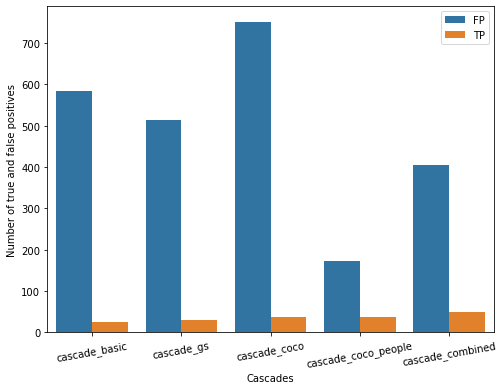

In [92]:
r = results.xs(100, level=1, axis=0)
df = r.loc[['FP', 'TP'], ['cascade_basic', 'cascade_gs', 'cascade_coco', 'cascade_coco_people', 'cascade_combined']].T.reset_index()
m = pd.melt(df, id_vars='index')

plt.figure(figsize=(8, 6))
gg = sns.barplot(data=m, x='index', y = 'value', hue='variable')
plt.gca().legend().set_title('')
plt.xlabel('Cascades')
plt.ylabel('Number of true and false positives')
gg.set_xticklabels(gg.get_xticklabels(), rotation=10)
plt.savefig('cascades_fp_tp.pdf')

Now we will compare how training parameters `-mode ALL` and `-maxFalseAlarmRate 0.3` improve cascade trained on first
positive image set.

In [ ]:
r = results.xs(100, level=1, axis=0)
df = r.loc[['FP', 'TP'], ['cascade_basic', 'cascade_basic_maxFAR03', 'cascade_basic_all', 'cascade_basic_all_maxFAR03']].T.reset_index()
m = pd.melt(df, id_vars='index')

plt.figure(figsize=(8, 6))
gg = sns.barplot(data=m, x='index', y = 'value', hue='variable')
plt.gca().legend().set_title('')
plt.xlabel('Cascades')
plt.ylabel('Number of true and false positives')
gg.set_xticklabels(gg.get_xticklabels(), rotation=10)
plt.savefig('cascades_fp_tp.pdf')


